# Wind Impact on LSTM Agent Performance

How robust is the RL architecture trained with wind estimations (from an LSTM) all wind?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from stable_baselines3 import PPO
from parameters import pid_params
from trajectories import nasa_wp

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('../../uav-controller/code/')

In [3]:
from controller import DisturbanceRejectionController

In [4]:
# study, best_agent, best_params = get_agent('windlstm')

# best_params['bounding_rect_length']=200
# best_params['steps_u']=50

In [5]:
# best_agent = PPO.load('./saved_models/higher_actions/58') 
best_agent = PPO.load('./saved_models/higher_actions_noZ/96') 
# best_agent = PPO.load('./saved_models/bad_pid/27') 


In [6]:
# pid_parameters = pid_params()
pos_mult = 1
vel_mult = 1
pid_parameters = pid_params(
    pos_p=[pos_mult*0.3, pos_mult*0.3, 0.2],
    vel_p=[vel_mult*1, vel_mult*1, 100],
    vel_i=[vel_mult*0.1, vel_mult*0.1, 0]
)

In [7]:
best_params = {'steps_u':50, 'scaling_factor':1, 'window_distance':23, 'pid_parameters':pid_parameters}

In [8]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
square_wpts = np.array([[0,100,30], [100,100,30], [100,200,30], [0,200,30], [0,300,30], [100,300,30], [100,400,30], [0,400,30], [0,0,30]])

In [9]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [10]:
import numpy as np

def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray) -> np.ndarray:
    """
    Calculates the trajectory tracking error.
    The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

    Parameters
    ----------
    initial_pos : tuple
        the initial position of the UAV.
    waypoints : np.ndarray
        the reference positions at each point in time.
    x : np.ndarray
        the x positions of the UAV.
    y : np.ndarray
        the y positions of the UAV.
    z : np.ndarray
        the z positions of the UAV.

    Returns
    -------
    np.ndarray
        the trajectory tracking error at each point in time.
    """
    ttes = []
    prev = initial_pos
    for i, waypoint in enumerate(waypoints):
        if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
            prev = waypoints[i-1]

        next_wp = waypoints[i]
        v1 = next_wp - prev
        v2 = np.array([x[i], y[i], z[i]]) - prev
        tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
        ttes.append(tte)

    return np.array(ttes)


In [11]:
def toc(tte: np.ndarray):
    corridor = 2
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [12]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [13]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("lstm", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    env.wp_options = [square_wpts]
    env.base_env.fault_type = None
    # env.base_env.fault_t = 0
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, 
                      other_vars=('reward','next_wp', 'disturbance_pred', 'disturbance', 'lstm_input', 'agent_actions', 'observations', 'wind_x', 'wind_y',
                                  'inertial_x', 'inertial_y', "intersection"))
    inputs = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        # if env.base_env.vehicle.position[1] > 20:
        #     action = [-0.1,0,0]
        # else:
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, disturbance_pred=env.base_env.disturbance_pred, 
                disturbance=env.base_env.disturbance, lstm_input=env.base_env.lstm_input, agent_actions=action,
                observations=env.base_env.observed_state, wind_x=env.base_env.wind_x, wind_y=env.base_env.wind_y, 
                inertial_x=env.base_env.vehicle.inertial_velocity[0], inertial_y=env.base_env.vehicle.inertial_velocity[1], intersection=state[12:15])
        inputs.append(np.array(env.base_env.lstm_input))
        

    log.done_logging()
    return log, info, np.array(inputs)

In [14]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, params):
    starting_pos = np.array([0, 0, 30])
    controller = DisturbanceRejectionController(starting_pos, True)

    env = env_selector.get_env("lstm", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    env.wp_options = [square_wpts]
    env.base_env.fault_type = None
    # env.base_env.fault_t = 0
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, 
                      other_vars=('reward','next_wp', 'disturbance_pred', 'disturbance', 'lstm_input', 'agent_actions', 'observations', 'wind_x', 'wind_y',
                                  'inertial_x', 'inertial_y', "intersection"))
    inputs = []
    while not done:
        action = controller.control(env.base_env.vehicle.position, env.base_env.vehicle.inertial_velocity, 
                                    env.base_env.vehicle.orientation, env.base_env.vehicle.angular_rate, 
                                    env.base_env.next_waypt, env.base_env.prev_waypt)[1]
        # if env.base_env.vehicle.position[1] > 20:
        #     action = [-0.1,0,0]
        # else:
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, disturbance_pred=env.base_env.disturbance_pred, 
                disturbance=env.base_env.disturbance, lstm_input=env.base_env.lstm_input, agent_actions=action,
                observations=env.base_env.observed_state, wind_x=env.base_env.wind_x, wind_y=env.base_env.wind_y, 
                inertial_x=env.base_env.vehicle.inertial_velocity[0], inertial_y=env.base_env.vehicle.inertial_velocity[1], intersection=state[12:15])
        inputs.append(np.array(env.base_env.lstm_input))
        

    log.done_logging()
    return log, info, np.array(inputs)

In [15]:
# log, info, inputs = run_trajectory(env_selector, [(8.5,8.5), (8.5,8.5), (0,0)], best_agent, best_params)
# log, info, inputs = run_trajectory(env_selector, [(7,7), (0,0), (0,0)], best_agent, best_params)
log, info, inputs = run_trajectory(env_selector, [(0,0), (0,0), (0,0)], best_params)

Text(0, 0.5, 'Y Position (m)')

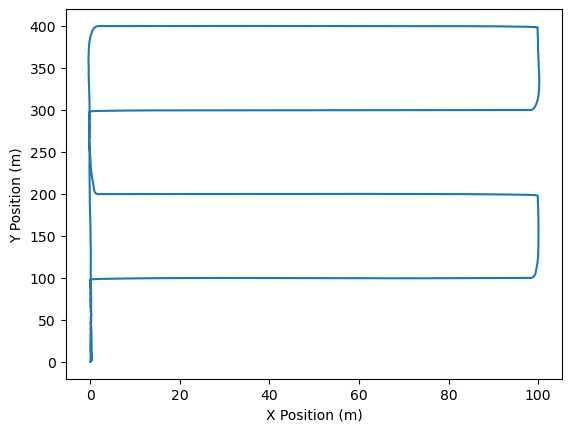

In [18]:
plt.plot(log.x, log.y)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")

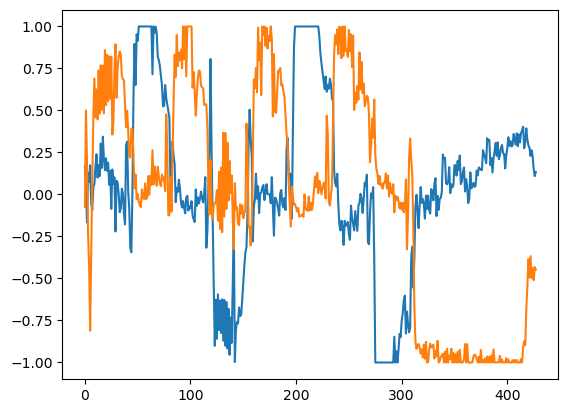

In [25]:
plt.plot(log.agent_actions)

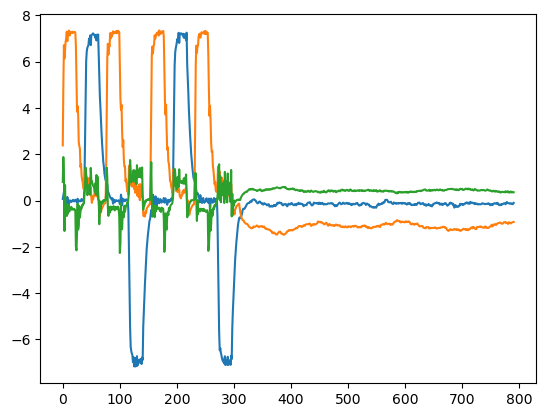

In [22]:
plt.plot(log.velocity)


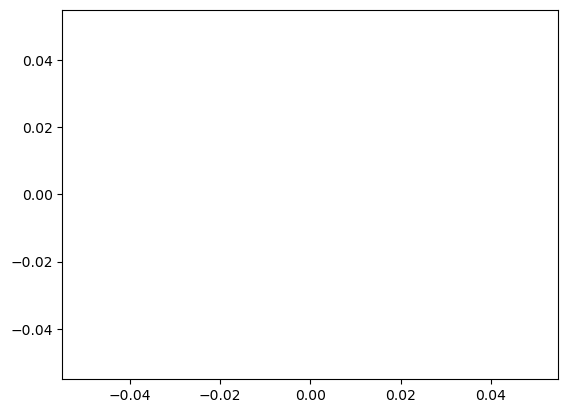

In [21]:
plt.plot(log.target.velocity)

In [ ]:
def save_video_data(log, tte):
    X = log.x
    Y = log.y
    Z = log.z
    
    roll = log.roll
    pitch = log.pitch
    yaw = log.yaw
    
    wp_x = log.next_wp[:,0]
    wp_y = log.next_wp[:,1]
    wp_z = log.next_wp[:,2]
    
    wind_x = log.wind_x
    wind_y = log.wind_y
    
    data_array = np.vstack([X, Y, Z, roll, pitch, yaw, wp_x, wp_y, wp_z, tte, wind_x, wind_y]).T
    df = pd.DataFrame(data_array, columns=[['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw', 'WPX', 'WPY', 'WPZ', 'TTE', 'Wind X', 'Wind Y']])
    # df.to_csv('./data/square_full_loss.csv')

In [ ]:
np.max(get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z))

1.9944030562278445

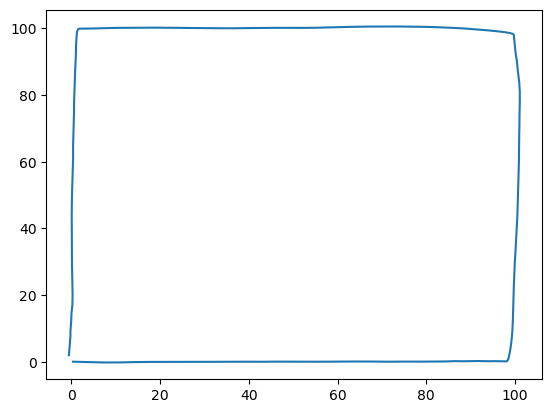

In [ ]:
plt.plot(log.x, log.y)

In [16]:
len(log.x) / 2

117.0

In [25]:
np.max(get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z))

1.9959792891222383

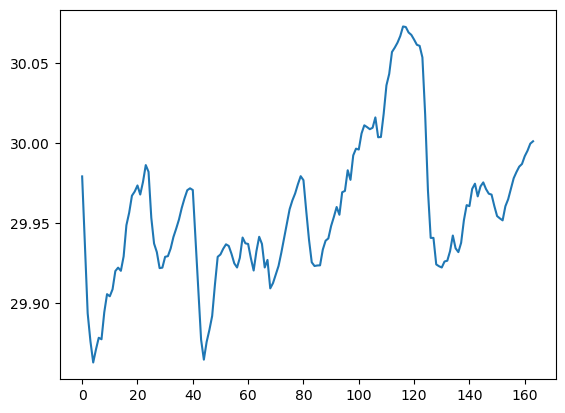

In [26]:
plt.plot(log.z)

In [19]:
# save_video_data(log, tte=get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z))

Text(0.5, 1.0, 'RL with Full Loss')

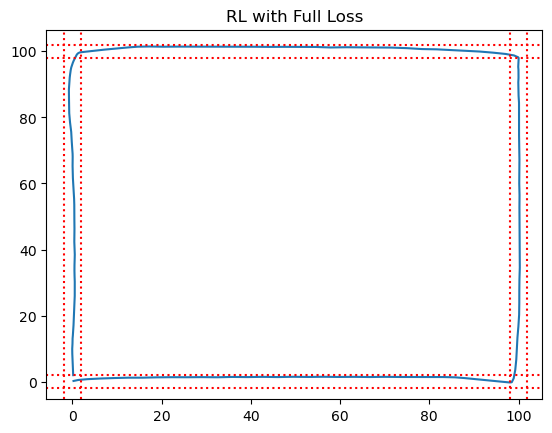

In [23]:
plt.plot(log.x, log.y)

plt.axvline(x=98, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=102, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=-2, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=2, ymin=0, ymax=100, linestyle=':', color='red')

plt.axhline(y=98, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=102, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=-2, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=2, xmin=0, xmax=100, linestyle=':', color='red')
plt.title("RL with Full Loss")

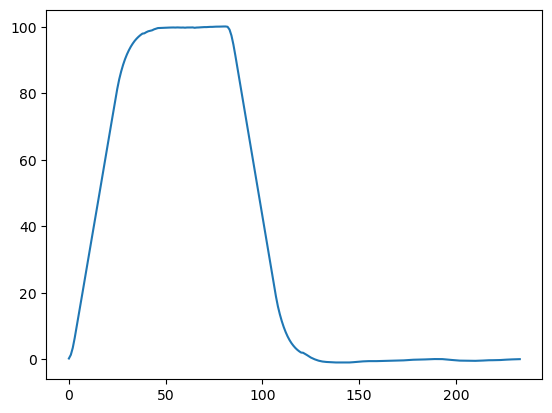

In [21]:
plt.plot(log.x)

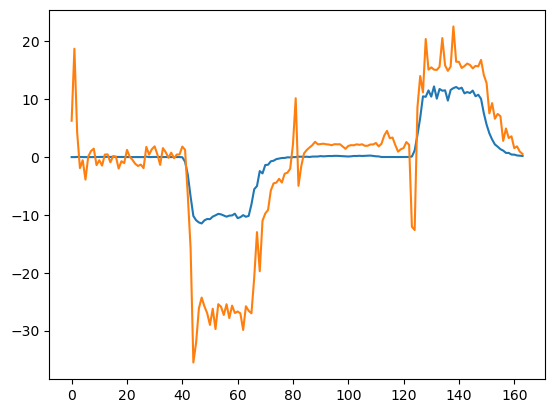

In [28]:
plt.plot(log.disturbance[:,1])
plt.plot(log.disturbance_pred[:,1])

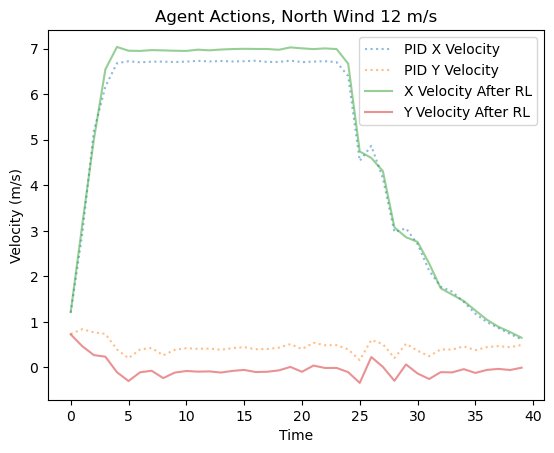

In [61]:
plt.plot(log.inertial_x[:40]-log.agent_actions[:40,0]/2, alpha=0.5, label='PID X Velocity', linestyle=':')
plt.plot(log.inertial_y[:40]-log.agent_actions[:40,1]/2, alpha=0.5, label='PID Y Velocity', linestyle=':')
plt.plot(log.inertial_x[:40], alpha=0.5, label='X Velocity After RL')
plt.plot(log.inertial_y[:40], alpha=0.5, label='Y Velocity After RL')
plt.title("Agent Actions, North Wind 12 m/s")
plt.xlabel("Time")
plt.ylabel("Velocity (m/s)")
plt.legend()

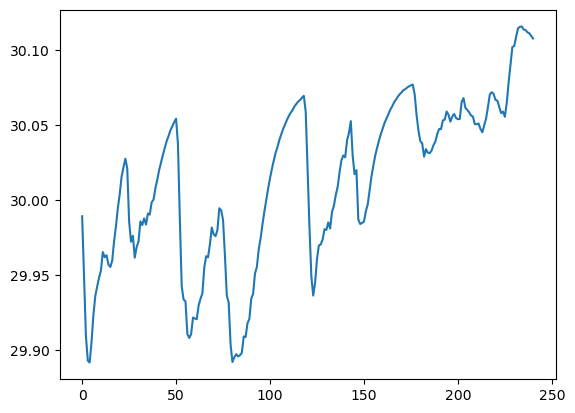

In [23]:
plt.plot(log.z)

In [24]:
toc(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

0.0

In [25]:
np.mean(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

0.33850532212240125

In [27]:
wind_range_dict = {
    'zero': [(0,0), (0,0), (0,0)],
    'n5': [(0,0), (5,5), (0,0)],
    'n7': [(0,0), (7,7), (0,0)],
    'n10': [(0,0), (10,10), (0,0)],
    'n12': [(0,0), (12,12), (0,0)],
    's5': [(0,0), (-5,-5), (0,0)],
    's7': [(0,0), (-7,-7), (0,0)],
    's10': [(0,0), (-10,-10), (0,0)],
    's12': [(0,0), (-12,-12), (0,0)],
    'e5': [(5,5), (0,0), (0,0)],
    'e7': [(7,7), (0,0), (0,0)],
    'e10': [(10,10), (0,0), (0,0)],
    'e12': [(12,12), (0,0), (0,0)],
    'w5': [(-5,-5), (0,0), (0,0)],
    'w7': [(-7,-7), (0,0), (0,0)],
    'w10': [(-10,-10), (0,0), (0,0)],
    'w12': [(-12,-12), (0,0), (0,0)],
    'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    'nw12': [(-8.5,-8.5), (8.5,8.5), (0,0)],
    'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'sw12': [(-8.5,-8.5), (-8.5,-8.5), (0,0)],
    'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    'ne12': [(8.5,8.5), (8.5,8.5), (0,0)],
    'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'se12': [(8.5,8.5), (-8.5,-8.5), (0,0)],
}

In [28]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Max TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [29]:
def run_wind_sweep(results, wind_dict, agent, params):
    for wind in tqdm(wind_dict.keys()):
        log, info, _ = run_trajectory(env_selector, wind_dict[wind], agent, params)
        if not info['reached']:
            print(f'FAILED {wind_dict[wind]}')
        traj_err = get_tte(np.array([0,0,30]), log.next_wp, log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Max TTE': np.max(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results, log

In [30]:
wind_results, log = run_wind_sweep(wind_results, wind_range_dict, best_agent, best_params)

  0%|          | 0/33 [00:00<?, ?it/s]/tmp/ipykernel_4141192/1564500133.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)
 64%|██████▎   | 21/33 [05:52<04:30, 22.55s/it]

FAILED [(-8.5, -8.5), (8.5, 8.5), (0, 0)]


100%|██████████| 33/33 [08:39<00:00, 15.74s/it]


In [31]:
wind_results.to_csv('./data/lstm_wind.csv')

In [32]:
wind_results = pd.read_csv('./data/lstm_wind.csv') 

In [33]:
wind_results

,Unnamed: 0,Wind,Total TTE,Mean TTE,Max TTE,Completed Mission,Reward,Time Outside Corridor
0,0,zero,33.970622,0.183625,0.998146,True,1676.00490,0.0
1,1,n5,44.946315,0.241647,0.985199,True,1566.08720,0.0
2,2,n7,59.551251,0.310163,0.983848,True,1421.40870,0.0
3,3,n10,99.806730,0.319893,0.986761,True,1005.10030,0.0
4,4,n12,78.943940,0.290235,1.348561,True,1227.51700,0.0
5,5,s5,36.615319,0.198996,0.995020,True,1650.23970,0.0
6,6,s7,51.626750,0.279064,0.994955,True,1498.55350,0.0
7,7,s10,69.377208,0.321191,0.991781,True,1311.35960,0.0
8,8,s12,67.495996,0.260602,1.219470,True,1340.49830,0.0
9,9,e5,34.584923,0.184946,0.997509,True,1672.33340,0.0


In [34]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Reward'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Reward'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Reward'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Reward'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Reward'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Reward'].std())

Mean reward for 5 m/s:  1645.957075
Std reward for 5 m/s:  51.86022757216199
Mean reward for 7 m/s:  1532.9652624999999
Std reward for 7 m/s:  67.81317728119848
Mean reward for 10 m/s:  1248.6981625
Std reward for 10 m/s:  146.98867733667626


In [35]:
print("Mean for 0 m/s: ", wind_results[wind_results['Wind'].str.contains("zero")]['Mean TTE'].mean())
print("Mean for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].mean())
print("Std for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].std())
print("Mean for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].mean())
print("Std for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].std())
print("Mean for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].mean())
print("Std for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].std())
print("Mean for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].mean())
print("Std for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].std())

Mean for 0 m/s:  0.1836249862422241
Mean for 5 m/s:  0.19991220167542928
Std for 5 m/s:  0.027298923629272262
Mean for 7 m/s:  0.25817984095470137
Std for 7 m/s:  0.03437013570951155
Mean for 10 m/s:  0.3620077382418237
Std for 10 m/s:  0.07083782188379356
Mean for 12 m/s:  0.48520572703617015
Std for 12 m/s:  0.2521674601514066


In [36]:
print("Max for 0 m/s: ", wind_results[wind_results['Wind'].str.contains("zero")]['Max TTE'].mean())
print("Max for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Max TTE'].mean())
print("Std for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].std())
print("Max for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Max TTE'].mean())
print("Std for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].std())
print("Max for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Max TTE'].mean())
print("Std for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].std())
print("Max for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Max TTE'].mean())
print("Std for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].std())

Max for 0 m/s:  0.998145818265612
Max for 5 m/s:  0.9929760261420171
Std for 5 m/s:  0.027298923629272262
Max for 7 m/s:  0.9874217697583507
Std for 7 m/s:  0.03437013570951155
Max for 10 m/s:  0.9939667748876656
Std for 10 m/s:  0.07083782188379356
Max for 12 m/s:  1.2899442509401293
Std for 12 m/s:  0.2521674601514066


In [37]:
print("Mean TOC for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].mean())
print("Std TOC for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].std())
print("Mean TOC for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].mean())
print("Std TOC for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].std())
print("Mean TOC for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].mean())
print("Std TOC for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].std())
print("Mean TOC for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Time Outside Corridor'].mean())
print("Std TOC for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Time Outside Corridor'].std())

Mean TOC for 5 m/s:  0.0
Std TOC for 5 m/s:  0.0
Mean TOC for 7 m/s:  0.0
Std TOC for 7 m/s:  0.0
Mean TOC for 10 m/s:  0.0
Std TOC for 10 m/s:  0.0
Mean TOC for 12 m/s:  0.0
Std TOC for 12 m/s:  0.0


In [38]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].std())

Mean reward for 5 m/s:  1.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  1.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  1.0
Std reward for 10 m/s:  0.0
